# Transaction Scheduling with Conflicts

This project explores different ways of scheduling transactions with conflicts using quantum computing techniques. We will start by giving a general introduction to the data used for experiments. We will see how this problem can be mapped to quadratic unconstrained binary optimization (QUBO) problems which are a way to represent optimization problems mathematically. Additionally, we will discuss ways of creating QUBOs from problems with continuous lengths for the transactions. Then, we will recreate the results from the paper by Tim Bittner and Sven Groppe [1] using a prepared dataset with coninuous length transaction scheduling problems. Afterwards, we will apply the knowledge and transfer the problem to the variational quantum eigensolver (VQE) and quantum approximate optimization algorithm (QAOA). Finally, we will compare Simulated Annealing, VQE, QAOA and an exact solver.

## Setup

In order to use this notebook, a Python environment is required. Please note, that the notebook has only been tested using Python version 3.8. Some APIs might not work with later versions and dependency issues could arise.

Before you can run any cell, you need to setup your environment to run jupyter notebooks. Here, we assume, you know how to do that.

Please run the following cell to install all necessary requirements. This is only required the first time you use this notebook in a new environment. If you encounter a `CompileError`, please try to install the packages of the requirements one by one using

```console
pip install <PACKAGE>==<VERSION>
```

In [ ]:
import sys

dependencies = [
    "dwave-ocean-sdk==6.7.1",
    "pyqubo==1.4.0",
    "qiskit==0.45.2",
    "qiskit-algorithms==0.2.2",
    "qiskit-optimization==0.6.0",
    "matplotlib==3.7.4",
    "qiskit-aer==0.13.2",
    "pydantic==2.5.3",
]
dep_str = " ".join(dependencies)
!{sys.executable} -m pip install {dep_str}

In [2]:
import matplotlib.pyplot as plt

from collections import defaultdict
from dwave.samplers import SimulatedAnnealingSampler
from pathlib import Path
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_algorithms import NumPyMinimumEigensolver, QAOA, SamplingVQE
from qiskit_algorithms.optimizers import COBYLA
from qiskit_algorithms.utils import algorithm_globals
from qiskit.circuit.library import TwoLocal
from qiskit.primitives import Sampler
from typing import List

from src.dataset import Dataset, read_dataset
from src.io_model import DataModel, append_data_to_file, \
    read_json_lines_file_to_pydantic
from src.qubo import build_discrete_qubo, convert_to_qiskit
from src.solver import simulated_annealing_solver, exact_solver, qaoa_solver, \
    sampling_vqe_solver
from src.task import TransactionScheduleTask
from src.transformation import binary_variables_to_solution_order

In [3]:
algorithm_globals.random_seed = 1

## Data

An example of a single entry of our datasets may look like this:
```python
# SchedulingWithConflicts_n3_m2.txt
[2,1,1] [[0,0,0],[0,0,1],[0,1,0]] [1,0,2]
```
The filename tells us that we have `n=3` transactions and `m=2` machines to execute the transactions.

The first array specifies the length of the transactions. The position of the length identifies the transaction. For example, the `2` tells us that transaction 0 has a length of two time units. Here, we do not specify what the unit is and we can ignore it for the purposes of this demonstration.

The second array is two-dimensional and tells us which transactions have conflicts and therefore, cannot run in parallel. You can read this as a symmetric matrix. In the example, transactions one and two are in conflict, meaning that they cannot run in parallel.

The last array shows an example solution. The numbers represent the transactions. The way this representation can be mapped to the actual schedule is as follows. Take the next transaction from the array. The transaction is given to the core that has the lowest processing time up to that transaction. If two or more cores have the same processing time, the one with the lowest order (index) is chosen. A transaction starts as soon as possible, but must take into account conflicts and the processing times of other transactions on that core before it. We will call this the **"processing time format,"** below. Note that there may be multiple solutions that lead to the same result.

Here we read the data set shown above. This data set contains only one sample for simplicity.

In [4]:
dataset = read_dataset(Path('data/SchedulingWithConflicts_n3_m2.txt'))

You can see what an example_task looks like and how the class works.

In [5]:
example_task = dataset.tasks[0]

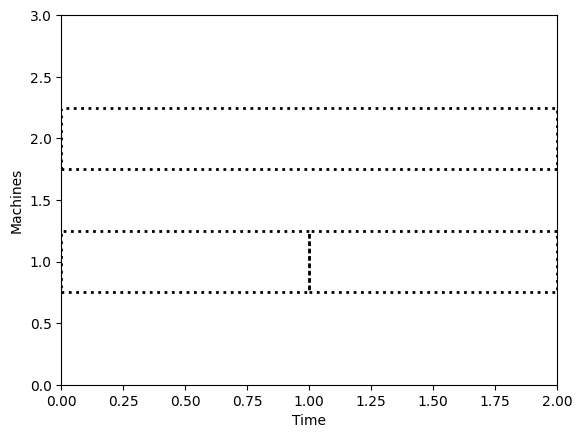

In [6]:
example_task.optimal_solution.visualize()

In [7]:
example_task.solution

array([1, 0, 2], dtype=uint8)

In [8]:
example_task.lengths

array([2., 1., 1.])

In [9]:
example_task.conflicts

array([[0, 0, 0],
       [0, 0, 1],
       [0, 1, 0]], dtype=uint8)

## Building QUBO problems

The paper [1] gives the details of how to construct QUBOs for discrete variations of the transaction scheduling problem. In reality, however, problems do not follow discrete time lengths. This is also true for the eight-transaction datasets. To construct the QUBOs, we need to specify fixed points in time at which a transaction can begin and end. For continuous problems, the number of available time points is infinite. Therefore, we need to be able to construct QUBO formulations based on non-discrete problems while preventing the search space from exploding. If we have `n` variables, the search space grows exponentially. Since we are using binary variables, we have `2^n` possible solutions.

One possible solution follows the work of Denkena et al. [2]. It proposes to discretise the problem by estimating a total runtime `R`. The runtime is divided into `T` equal time steps. The length of each transaction is discretised in the time steps. In order to provide a solution that is guaranteed to be correct, the ceiling function is used to map the number of time steps into a truly discrete time span. However, this may leave gaps which can be reduced by using the continuous times again and squeezing the result.

The second way is similar to the first one, but relies on prior knowledge. Instead of estimating a good time step length, we can choose it ourselves. For our example dataset that could be a time step of length 1.

**NOTE:** In order to replicate the examples of paper [1], it was necessary to adapt the computation of `p` for `B` and `C` by adding a `-1`: `min{s_1 + l_i_1 - 1, r_i_2}`.

In [10]:
# Define number of time steps.
qubo, offset = build_discrete_qubo(
    task=example_task,
    number_time_steps=2
)
len(qubo), offset

(39, 3.0)

In [11]:
# Define length of time steps.
qubo, offset = build_discrete_qubo(
    task=example_task,
    time_step_length=1
)
len(qubo), offset

(39, 3.0)

Next, we show how we create a solution order as given by the dataset from binary variables.

In [12]:
binary_variables_to_solution_order(['1-2-0', '2-1-1', '3-1-0'], example_task)

[2, 0, 1]

## Solving a Problem

Now, we use different techniques to approximate the ground state of the Hamiltonian (objective function/QUBO) for our example task.

In [13]:
# Simulated "Quantum Annealing"
simulated_annealing_sampler = SimulatedAnnealingSampler()

# Exact method
exact = NumPyMinimumEigensolver()
exact_opt = MinimumEigenOptimizer(exact)

# VQE
ansatz = TwoLocal(rotation_blocks="ry", entanglement_blocks="cz")
svqe = SamplingVQE(sampler=Sampler(), ansatz=ansatz, optimizer=COBYLA())
svqe_opt = MinimumEigenOptimizer(svqe)

# QAOA
qaoa = QAOA(sampler=Sampler(), optimizer=COBYLA(), initial_point=[0.0, 0.0])
qaoa_opt = MinimumEigenOptimizer(qaoa)

In [14]:
qubo, offset = build_discrete_qubo(
    task=example_task,
    time_step_length=1
)
quadratic_program = convert_to_qiskit(qubo, offset)

In [15]:
sampleset = simulated_annealing_sampler.sample_qubo(qubo, num_reads=500)
print(sampleset.aggregate())

  1-1-0 1-2-0 2-1-0 2-1-1 2-2-0 2-2-1 3-1-0 3-1-1 3-2-0 3-2-1    energy num_oc.
0     1     0     0     0     0     1     0     0     1     0 -2.222222     120
1     0     1     0     1     0     0     1     0     0     0 -2.222222     138
2     1     0     0     0     1     0     0     0     0     1 -2.222222     113
3     0     1     1     0     0     0     0     1     0     0 -2.222222     128
4     0     0     0     0     1     0     0     1     0     0 -1.555556       1
['BINARY', 5 rows, 500 samples, 10 variables]


In [16]:
exact_res = exact_opt.solve(quadratic_program)
print(exact_res.prettyprint())

objective function value: 0.7777777777777777
variable values: 1-1-0=0.0, 2-2-1=0.0, 2-1-0=1.0, 3-2-0=0.0, 1-2-0=1.0, 3-1-1=1.0, 2-1-1=0.0, 2-2-0=0.0, 3-2-1=0.0, 3-1-0=0.0
status: SUCCESS


In [17]:
svqe_result = svqe_opt.solve(quadratic_program)
print(svqe_result.prettyprint())

objective function value: 0.7777777777777777
variable values: 1-1-0=1.0, 2-2-1=0.0, 2-1-0=0.0, 3-2-0=0.0, 1-2-0=0.0, 3-1-1=0.0, 2-1-1=0.0, 2-2-0=1.0, 3-2-1=1.0, 3-1-0=0.0
status: SUCCESS


In [18]:
qaoa_res = qaoa_opt.solve(quadratic_program)
print(qaoa_res.prettyprint())

objective function value: 0.7777777777777777
variable values: 1-1-0=1.0, 2-2-1=1.0, 2-1-0=0.0, 3-2-0=1.0, 1-2-0=0.0, 3-1-1=0.0, 2-1-1=0.0, 2-2-0=0.0, 3-2-1=0.0, 3-1-0=0.0
status: SUCCESS


## Analysis over multiple Problems

Here, we now perform an analysis over either several tasks or one task to compare the methods.

Run over multiple tasks of one dataset.

In [19]:
OUTPUT_PATH_MULTIPLE_TASKS: str = 'data/results_multiple_tasks.jsonl'
DATASET: Dataset = dataset
TIME_STEP_LENGTH: int = 1

In [20]:
for task in dataset.tasks:
    print(f'Current task index: {task.id}')
    qubo, offset = build_discrete_qubo(
        task=task,
        time_step_length=1
    )
    print('QUBO done.')
    
    for method in [simulated_annealing_solver, exact_solver, qaoa_solver, sampling_vqe_solver]:
        print('Method', method.__name__)
        res, exec_time = method(qubo, offset)
        print("Method done.")
        data = DataModel(
            dataset=DATASET.name,
            task_id=task.id,
            method=method.__name__,
            energy=res.energy,
            exec_time=exec_time,
            vars=res.active_vars,
        )
        append_data_to_file(OUTPUT_PATH_MULTIPLE_TASKS, data.model_dump_json())

Current task index: 0
QUBO done.
Method simulated_annealing_solver
Method done.
Method exact_solver
Method done.
Method qaoa_solver
Method done.
Method sampling_vqe_solver
Method done.


In [21]:
NUM_REPETITIONS: int = 3
OUTPUT_PATH_SINGLE_TASK: str = 'data/results_single_task.jsonl'
TASK: TransactionScheduleTask = example_task
TIME_STEP_LENGTH: int = 1

In [22]:
for i in range(NUM_REPETITIONS):
    print(f'Current repetition: {i}', end='\r')
    qubo, offset = build_discrete_qubo(
        task=TASK,
        time_step_length=TIME_STEP_LENGTH
    )
    
    for method in [simulated_annealing_solver, exact_solver, qaoa_solver, sampling_vqe_solver]:
        res, exec_time = method(qubo, offset)
        data = DataModel(
            dataset=DATASET.name,
            task_id=task.id,
            method=method.__name__,
            energy=res.energy,
            exec_time=exec_time,
            vars=res.active_vars,
        )
        append_data_to_file(OUTPUT_PATH_SINGLE_TASK, data.model_dump_json())

## Analysis

In [23]:
FILE_PATH = 'data/results_single_task_example.jsonl'

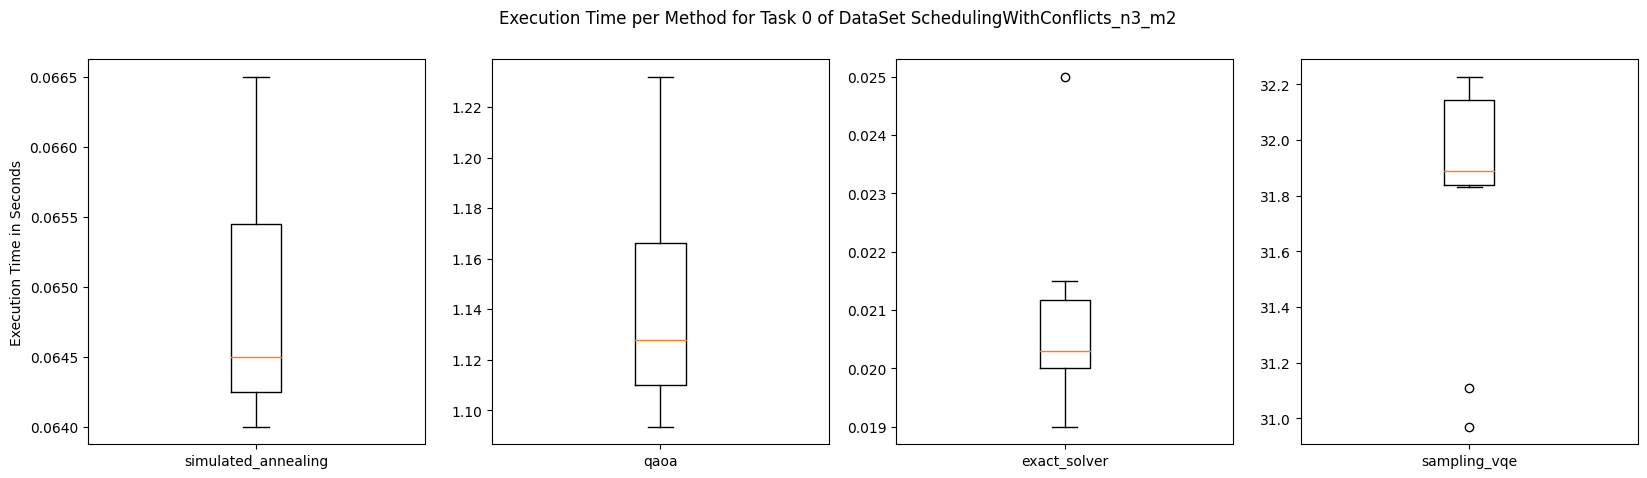

In [24]:
data: List[DataModel] = read_json_lines_file_to_pydantic(FILE_PATH, DataModel)

container = defaultdict(list)
for entry in data:
    container[entry.method].append(entry.exec_time)

fig, axes = plt.subplots(ncols=len(container.keys()), figsize=(20, 5))
for ax, val, label in zip(axes, container.values(), container.keys()):
    ax.boxplot(val, labels=[label])
axes[0].set_ylabel('Execution Time in Seconds')
fig.suptitle(f'Execution Time per Method for Task {data[0].task_id} of DataSet {data[0].dataset}')
plt.show()

The figure shows the execution time in seconds for each method. As the range of execution times is different for each method, separate graphs are shown with separate y-axes.

The figure shows that SamplingVQE has the longest execution time at over 30 seconds, while the exact solver has the lowest at well under a quarter of a second. The exact solver is followed by Simulated Annealing in second place and QAOA in third.

## Sources

[1] Tim Bittner and Sven Groppe. 2020. Avoiding blocking by scheduling transactions using quantum annealing. In Proceedings of the 24th Symposium on International Database Engineering & Applications (IDEAS '20). Association for Computing Machinery, New York, NY, USA, Article 21, 1–10. https://doi.org/10.1145/3410566.3410593

[2] Berend Denkena, Fritz Schinkel, Jonathan Pirnay, and Sören Wilmsmeier. 2021. Quantum algorithms for process parallel flexible job shop scheduling. In CIRP Journal of Manufacturing Science and Technology. The International Academy for Production Engineering, Paris, France. Volume 33, 100-114. https://doi.org/10.1016/j.cirpj.2021.03.006

[3] Jules Tilly, Hongxiang Chen, Shuxiang Cao, Dario Picozzi, Kanav Setia, Ying Li, Edward Grant, Leonard Wossnig, Ivan Rungger, George H. Booth, and Jonathan Tennyson. 2022. The Variational Quantum Eigensolver: A review of methods and best practices. In Physics Reports. Volume 986, 1-128. https://doi.org/10.1016/j.physrep.2022.08.003

[4] Edward Farhi, Jeffrey Goldstone, and Sam Gutmann. 2014. A Quantum Approximate Optimization Algorithm. In arXiv. https://doi.org/10.48550/arXiv.1411.4028